# Examples and calculations for the hypertext-conference dataset

In [1]:
import copy
import numpy as np
import xgi
import pandas
from itertools import permutations
from itertools import combinations
from collections import Counter, defaultdict

import matplotlib.pyplot as plt

import sys
sys.path.append("..") 
from hyperfunctions import *
from other_measures import *

We can load the dataset from XGI directly. 

In [2]:
H = xgi.load_xgi_data("hypertext-conference")

In [3]:
len(H.nodes), len(H.edges), H.edges.size.max()

(113, 19036, 6)

In [4]:
H.remove_edges_from(H.edges.singletons()) # Remove edges with a single node in them (there are ~5000)
H.remove_nodes_from(H.nodes.isolates())   # There are 6 nodes which only belonged to those singleton edges, we remove them as well.
# Relabel all nodes to start from zero to the current number of nodes
H = xgi.convert_labels_to_integers(H)

H.cleanup(connected=False) #This basically does the same as the three above + checks for multiedges and removes them

In [5]:
len(H.nodes), len(H.edges), H.edges.size.max()

(113, 2434, 6)

In [6]:
xgi.is_connected(H)

True

### What centralities to compute:
Minimum and maximum orders at which to compute centralities

In [7]:
Mmin = 2
Mmax = None # Can be None 

UniformC = False # whether to compute or not Benson's centralities

if not Mmax:
    Mmax = H.edges.size.max()

## Hypergraph statistics

In [8]:
print("Complete")
len(H.nodes), len(H.edges), H.edges.size.max()

Complete


(113, 2434, 6)

In [9]:
sizes = defaultdict(int)
for edge in H.edges.members():

    if len(edge) == 0:
        print(edge)
    sizes[len(edge)] += 1

<BarContainer object of 5 artists>

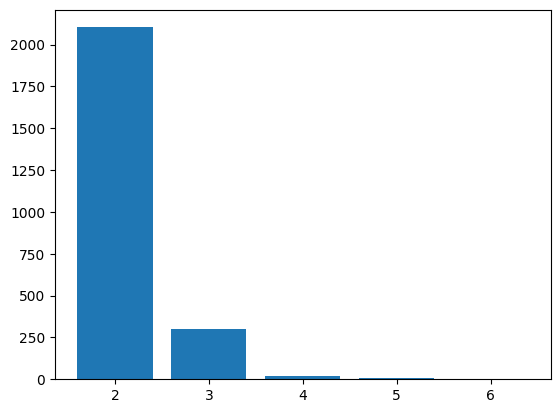

In [10]:
plt.bar(sizes.keys(), sizes.values())

In [11]:
edgedict = H.edges.members(dtype=dict)

In [12]:
Hunif = {}
for m in sizes.keys():
    
    Hunif[m] = uniform_section(H, edgedict, m)

    print("Order", m)
    print(len(Hunif[m].nodes), len(Hunif[m].edges), (Hunif[m].edges.size.min(), Hunif[m].edges.size.max()), len(Hunif[m].nodes)/len(H.nodes))
    print("---")

Order 3
105 302 (3, 3) 0.9292035398230089
---
Order 2
113 2103 (2, 2) 1.0
---
Order 4
11 12 (4, 4) 0.09734513274336283
---
Order 5
8 7 (5, 5) 0.07079646017699115
---
Order 6
8 4 (6, 6) 0.07079646017699115
---


## Order 2 - pure CEC 

In [13]:
cec = xgi.clique_eigenvector_centrality(H)

df = pandas.DataFrame({"CEC": cec})

## UPHEC at different orders

In [14]:
for m in range(Mmin,Mmax + 1):

    print("Order", m)
    
    Tm = uniform_adjacency_combinatorial_tensor(H, m=m, math_notation=False)
    
    centm = HEC_ours(Tm, m=m, niter=100000, tol=1e-6, verbose=True)

    # Remove last node (auxiliary) from uplift
    if m > 2:
        centm = centm[0][:-1] #extract last node
        centm /= np.sum(centm) # normalize
        df[f"UPHEC-{m}"] = centm
    else:
        df[f"UPHEC-{m}"] = centm[0]

    print("---")

Order 2
Finished in 10 iterations.
---
Order 3
Finished in 19 iterations.
---
Order 4
Finished in 28 iterations.
---
Order 5
Finished in 34 iterations.
---
Order 6
Finished in 30 iterations.
---


## Uniform HEC at each order (as in Benson's work)

In [15]:
for m in sizes.keys():

    centmunif = xgi.algorithms.h_eigenvector_centrality(Hunif[m])
    
    for missing_node in range(len(H.nodes)):
        if missing_node not in centmunif.keys():
            centmunif[missing_node] = 0
    
    df[f"HEC-{m}unif"] = centmunif

## Alternative uniformization scheme at different orders

### Order 2 == the same as the UPHEC

### Order 3 - onwards

In [16]:
for m in range(Mmin, Mmax + 1):

    print("Order", m)
    
    Tmalt = alternative_uniformization(H, m=m, math_notation=False)
    
    centmalt = HEC_ours(Tmalt, m=m, niter=100000, tol=1e-6, verbose=True)
    
    if centmalt[1]:
        df[f"AltUnif-{m}"] = centmalt[0]
        
    print("---")

Order 2
Finished in 10 iterations.
---
Order 3
Finished in 21 iterations.
---
Order 4
Finished in 27 iterations.
---
Order 5
Finished in 21 iterations.
---
Order 6
Finished in 19 iterations.
---


## Save everything

In [18]:
df.to_csv("../Output/hypertext_dataframe.csv", index=False)

In [ ]:
#df1 = pandas.read_csv("../Output/diseasome_dataframe.csv")

In [ ]:
#df2 = df1.join(df)

In [ ]:
#df2.to_csv("../Output/diseasome_dataframe.csv", index=False)

In [ ]:
#df2